In [309]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

import warnings
warnings.filterwarnings('ignore') 


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the full CIFAR10 test set (10,000 samples)
full_testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform)

# Calculate split sizes
val_size = int(0.8 * len(full_testset))  # 7000
test_size = len(full_testset) - val_size  # 3000

# Randomly split into validation and test subsets
val_set, test_set = random_split(
    full_testset, [val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Create DataLoaders
valloader = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=2)
testloader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

print(f"Validation samples: {len(val_set)}")
print(f"Test samples: {len(test_set)}")

val_indices = val_set.indices
test_indices = test_set.indices

Validation samples: 8000
Test samples: 2000


In [310]:
import os 
import json 

full_testset_indices = list(range(len(full_testset)))  # 0..9999 for CIFAR100 test
out_dir = "./"
with open(os.path.join(out_dir, "full_indices.json"), "w") as f:
    json.dump(full_testset_indices, f)

In [311]:
# -------------------- helper: recreate Subset from indices later --------------------
def load_split_subset(split_indices_path, transform=None):
    """
    Returns a Subset(dataset, indices) for the given saved indices file.
    Use this if you restart the kernel later and want the exact same split.
    """
    with open(split_indices_path, "r") as f:
        indices = json.load(f)
    dataset = torchvision.datasets.CIFAR100(root=data_root, train=False, download=True,
                                           transform=transform if transform is not None else transform)
    subset = Subset(dataset, indices)
    return subset

# -------------------- quick sanity check --------------------
# show a few labels distribution in validation set
from collections import Counter
val_labels = [full_testset[i][1] for i in val_indices]
test_labels = [full_testset[i][1] for i in test_indices]
print("Validation label counts (example):", Counter(val_labels).most_common(5))
print("Test label counts (example):", Counter(test_labels).most_common(5))

Validation label counts (example): [(87, 88), (51, 88), (84, 88), (10, 88), (8, 87)]
Test label counts (example): [(92, 32), (65, 30), (50, 29), (70, 29), (23, 28)]


In [312]:
out_dir = "./"

with open(os.path.join(out_dir, "val_indices.json"), "w") as f:
    json.dump(val_indices, f)
with open(os.path.join(out_dir, "test_indices.json"), "w") as f:
    json.dump(test_indices, f)

### Test Base models 

In [313]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import f1_score
import pandas as pd
from tqdm import tqdm
import json

# -------------------- config --------------------
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
batch_size = 128
num_workers = 4
models_root = "./trained_models_partitions"   # your folder with models
partitions_path = "./class_partitions.json"         # partition info
val_indices_path = "./full_indices.json"

# -------------------- list all trained models --------------------
print("📁 Listing all trained model files...")
model_files = sorted([f for f in os.listdir(models_root) if f.endswith(".pth")])
for f in model_files:
    print(" -", f)
print(f"\nTotal models found: {len(model_files)}")

# -------------------- load CIFAR100 validation subset --------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)),
])
full_test = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)

with open(val_indices_path, "r") as f:
    val_indices = json.load(f)
val_subset = Subset(full_test, val_indices)

# -------------------- load partitions --------------------
with open(partitions_path, "r") as f:
    partitions = json.load(f)

# -------------------- model creation helper --------------------
def create_model(arch, num_classes):
    if arch == "resnet50":
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif arch == "densenet169":
        model = models.densenet169(weights=None)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif arch == "mobilenet_v2":
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Unknown architecture: {arch}")
    return model.to(device)

# -------------------- evaluation helper --------------------
def evaluate_partition_model(model, partition_classes):
    indices = [i for i in range(len(val_subset)) if val_subset.dataset[val_subset.indices[i]][1] in partition_classes]
    if len(indices) == 0:
        return np.nan, np.nan
    loader = DataLoader(Subset(val_subset, indices), batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model.eval()
    preds_all, labels_all = [], []
    label_map = {c: i for i, c in enumerate(partition_classes)}
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = torch.tensor([label_map[int(l)] for l in labels]).to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    preds_all, labels_all = np.array(preds_all), np.array(labels_all)
    acc = 100 * (preds_all == labels_all).mean()
    f1 = f1_score(labels_all, preds_all, average='macro')
    return acc, f1

# -------------------- main evaluation loop --------------------
results = []

for file in model_files:
    try:
        # Example filename: densenet169_partition_4.pth
        parts = file.replace(".pth", "").split("_")
        arch = "_".join(parts[:-2])   # join all parts before 'partition'
        pid = int(parts[-1])          # last part is partition id
        partition_classes = partitions[str(pid)]
        model_path = os.path.join(models_root, file)

        print(f"\n🧠 Evaluating {file} ... ({len(partition_classes)} classes)")
        model = create_model(arch, num_classes=len(partition_classes))
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        acc, f1 = evaluate_partition_model(model, [full_test.class_to_idx[c] if isinstance(c, str) else c for c in partition_classes])
        print(f"✅ {arch}_p{pid}:  Acc={acc:.2f}% | F1={f1:.4f}")
        results.append({"Partition": pid, "Model": arch, "Accuracy": acc, "F1": f1})
    except Exception as e:
        print(f"⚠️ Error evaluating {file}: {e}")

# -------------------- results table --------------------
df = pd.DataFrame(results)
print("\n=== Summary Table ===")
print(df.pivot(index="Model", columns="Partition", values=["Accuracy", "F1"]).round(2))

# save results
df.to_csv("partition_validation_results.csv", index=False)
print("\n💾 Results saved to partition_validation_results.csv")


📁 Listing all trained model files...
 - densenet169_partition_0.pth
 - densenet169_partition_1.pth
 - densenet169_partition_2.pth
 - densenet169_partition_3.pth
 - densenet169_partition_4.pth
 - densenet169_partition_5.pth
 - densenet169_partition_6.pth
 - densenet169_partition_7.pth
 - mobilenet_v2_partition_0.pth
 - mobilenet_v2_partition_1.pth
 - mobilenet_v2_partition_2.pth
 - mobilenet_v2_partition_3.pth
 - mobilenet_v2_partition_4.pth
 - mobilenet_v2_partition_5.pth
 - mobilenet_v2_partition_6.pth
 - mobilenet_v2_partition_7.pth
 - resnet50_partition_0.pth
 - resnet50_partition_1.pth
 - resnet50_partition_2.pth
 - resnet50_partition_3.pth
 - resnet50_partition_4.pth
 - resnet50_partition_5.pth
 - resnet50_partition_6.pth
 - resnet50_partition_7.pth

Total models found: 24

🧠 Evaluating densenet169_partition_0.pth ... (2 classes)
✅ densenet169_p0:  Acc=89.00% | F1=0.8900

🧠 Evaluating densenet169_partition_1.pth ... (33 classes)
✅ densenet169_p1:  Acc=57.12% | F1=0.5640

🧠 Evaluat

In [314]:
df

,Partition,Model,Accuracy,F1
0,0,densenet169,89.000000,0.889989
1,1,densenet169,57.121212,0.564009
2,2,densenet169,79.214286,0.790773
3,3,densenet169,73.400000,0.730485
4,4,densenet169,75.909091,0.757921
5,5,densenet169,87.600000,0.875571
6,6,densenet169,49.400000,0.491125
7,7,densenet169,71.000000,0.707893
8,0,mobilenet_v2,91.000000,0.909919
9,1,mobilenet_v2,51.363636,0.514357


### CP-DES 

In [481]:
### import archetecture of models 

from model_codes_cifar100.resnet_cifar100 import * 
from model_codes_cifar100.densenet_cifar100 import * 
from model_codes_cifar100.mobilenetv2_cifar100 import *  

## getting the archetecture of model from models.vgg_models 
resnet50_model = resnet50() 
densenet169_model = densenet169() 
mobilenetv2_model = mobilenetv2()

trained_models_directory = "trained_models_cifar100/" 
device_name = 'cuda:2' 
device = torch.device(device_name if torch.cuda.is_available() else "cpu")


resnet50_model_file_name = "resnet50_cifar100.pth" 
densenet169_model_file_name = "densenet169_cifar100.pth" 
mobilenetv2_model_file_name = "mobilenetv2_cifar100.pth" 

resnet50_path = os.path.join(trained_models_directory, resnet50_model_file_name) 
densenet169_path = os.path.join(trained_models_directory, densenet169_model_file_name) 
mobilenetv2_path = os.path.join(trained_models_directory, mobilenetv2_model_file_name)

## load the model 
resnet50_model.load_state_dict(torch.load(resnet50_path, map_location=device_name)['net'])
densenet169_model.load_state_dict(torch.load(densenet169_path, map_location=device_name)['net'])
mobilenetv2_model.load_state_dict(torch.load(mobilenetv2_path, map_location=device_name)['net'])

global_models = [
    resnet50_model.to(device), 
    densenet169_model.to(device), 
    mobilenetv2_model.to(device)
] 

In [316]:
with open("class_partitions.json", "r") as f:
    partitions = json.load(f)

full_trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform)

In [318]:
import os
import torch

device = device_name if torch.cuda.is_available() else "cpu"
partition_models_dir = "./trained_models_partitions/"
# Define your model classes loader (replace with your own model constructors)
def create_model(model_name, num_classes):
    if model_name == "resnet50":
        from torchvision.models import resnet50
        model = resnet50(pretrained=False)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "densenet169":
        from torchvision.models import densenet169
        model = densenet169(pretrained=False)
        model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == "mobilenet_v2":
        from torchvision.models import mobilenet_v2
        model = mobilenet_v2(pretrained=False)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    return model

# Suppose you have a dict of partition -> class list
# Example: partitions = {"0": ['bed','bicycle',...], "1": [...], ...}
partition_models = {}

for pid, class_list in partitions.items():
    partition_models[pid] = {}
    num_classes = len(class_list)
    
    for model_name in ["resnet50", "densenet169", "mobilenet_v2"]:
        path = os.path.join(partition_models_dir, f"{model_name}_partition_{pid}.pth")
        if os.path.exists(path):
            model = create_model(model_name, num_classes)
            model.load_state_dict(torch.load(path, map_location=device))
            model.to(device)
            model.eval()
            partition_models[pid][model_name] = model
        else:
            print(f"⚠️ Model not found: {path}")


#### Step 1: Prepare CLIP embeddings and train KMeans 

In [325]:
import joblib

kmeans_file = "kmeans_partition_model.pkl"

# Load from disk
kmeans = joblib.load(kmeans_file)
print("KMeans loaded successfully")

KMeans loaded successfully


In [326]:
kmeans

,n_clusters,8
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [327]:
import timm 

dino_model = timm.create_model('vit_base_patch8_224.dino', pretrained=True).to(device)
dino_model.eval()  

print("DINO embedding models is loaded ")

DINO embedding models is loaded 


In [328]:
full_class_to_idx = full_trainset.class_to_idx
full_idx_to_class = {v: k for k, v in full_class_to_idx.items()}

In [329]:
import os
import numpy as np
import faiss
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm

device = "cuda:2" if torch.cuda.is_available() else "cpu"

# Load pretrained DINO model
dino_model = timm.create_model("vit_base_patch8_224.dino", pretrained=True).to(device)
dino_model.eval()

print("DINO embedding model loaded ✅")

os.makedirs("faiss_indices", exist_ok=True)

# Suppose you have:
# partitions = {pid: class_names_in_partition, ...}
# full_valset = CIFAR100(..., train=False, transform=val_transform)
# full_class_to_idx = full_valset.class_to_idx

for pid, cls_names in partitions.items():
    print(f"\nBuilding FAISS index for partition {pid} ({len(cls_names)} classes)")

    # Map partition classes → global class indices
    class_idxs = [full_class_to_idx[c] for c in cls_names]

    # Collect images from validation set belonging to this partition
    imgs, labels, global_indices = [], [], []
    for idx, (img, label) in enumerate(val_set):
        if label in class_idxs:
            imgs.append(img)
            labels.append(label)
            global_indices.append(idx)  # keep global index

    if not imgs:
        print(f"⚠️ No validation samples found for partition {pid}")
        continue

    loader = DataLoader(list(zip(imgs, labels, global_indices)), batch_size=32, shuffle=False)

    all_embs, all_labels, all_global_idx = [], [], []
    with torch.no_grad():
        for x, y, g_idx in tqdm(loader, desc=f"Partition {pid}"):
            x = x.to(device)
            # --- identical to VisionDES embedder ---
            if x.shape[1] == 1:
                x = x.repeat(1, 3, 1, 1)
            x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
            embs = dino_model.forward_features(x).cpu()
            all_embs.append(embs)
            all_labels.append(y)
            all_global_idx.extend(g_idx)  # store global indices

    # --- identical to VisionDES postprocessing ---
    all_embs = torch.cat(all_embs)
    cls_embs = all_embs[:, 0, :]  # CLS token
    cls_embs = np.ascontiguousarray(cls_embs.numpy(), dtype="float32")
    cls_embs /= np.linalg.norm(cls_embs, axis=1, keepdims=True)

    # Build FAISS index
    embedding_dim = cls_embs.shape[1]
    index = faiss.IndexFlatL2(embedding_dim)
    index.add(cls_embs)

    # Save index + metadata
    faiss.write_index(index, f"faiss_indices/partition_{pid}_index.faiss")
    
    # Flatten labels and convert to numpy
    flat_labels = []
    for batch_labels in all_labels:
        flat_labels.extend(batch_labels.cpu().numpy() if isinstance(batch_labels, torch.Tensor) else batch_labels)
    
    # Save as dictionary with labels + global indices
    partition_meta = {
        "labels": np.array(flat_labels, dtype=np.int64),       # local labels
        "global_indices": np.array(all_global_idx, dtype=np.int64)  # indices in full validation set
    }
    np.save(f"faiss_indices/partition_{pid}_meta.npy", partition_meta)
    
    print(f"✅ Saved partition {pid}: FAISS index + labels + global indices")


DINO embedding model loaded ✅

Building FAISS index for partition 0 (2 classes)


Partition 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.25it/s]


✅ Saved partition 0: FAISS index + labels + global indices

Building FAISS index for partition 1 (33 classes)


Partition 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [01:16<00:00,  1.07it/s]


✅ Saved partition 1: FAISS index + labels + global indices

Building FAISS index for partition 2 (14 classes)


Partition 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:33<00:00,  1.03it/s]


✅ Saved partition 2: FAISS index + labels + global indices

Building FAISS index for partition 3 (15 classes)


Partition 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:25<00:00,  1.52it/s]


✅ Saved partition 3: FAISS index + labels + global indices

Building FAISS index for partition 4 (22 classes)


Partition 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:34<00:00,  1.61it/s]


✅ Saved partition 4: FAISS index + labels + global indices

Building FAISS index for partition 5 (5 classes)


Partition 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


✅ Saved partition 5: FAISS index + labels + global indices

Building FAISS index for partition 6 (5 classes)


Partition 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.76it/s]


✅ Saved partition 6: FAISS index + labels + global indices

Building FAISS index for partition 7 (4 classes)


Partition 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.77it/s]


✅ Saved partition 7: FAISS index + labels + global indices


In [387]:
import torch
import numpy as np
import faiss
import clip 
from torchvision.transforms import ToPILImage, Compose, Resize, ToTensor, Normalize
from sklearn.cluster import KMeans

# ====== SETUP ======
device = "cuda:2" if torch.cuda.is_available() else "cpu"

# DINO preprocess
dino_preprocess = Compose([
    ToPILImage(),
    Resize((224, 224)),
    ToTensor(),
    # Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Load DINO model
import timm
dino_model = timm.create_model('vit_base_patch8_224.dino', pretrained=True).to(device)
dino_model.eval()

clip_model, preprocess = clip.load("ViT-B/32", device=device)

clip_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),   # ✅ Required for ViT-B/32 CLIP
])
 

def get_dino_embedding(img_tensor):
    # Ensure 3 channels
    if img_tensor.dim() == 4 and img_tensor.size(0) == 1:
        img_tensor = img_tensor.squeeze(0)
    if img_tensor.shape[0] == 1:
        img_tensor = img_tensor.repeat(3, 1, 1)

    # Resize to 224x224
    x = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False).to(device)
    
    with torch.no_grad():
        emb = dino_model.forward_features(x)
        cls_emb = emb[:, 0, :].cpu().numpy().astype('float32')
    return cls_emb  # shape: (1, D)


def clip_embed_from_tensor(img_tensor):
    # Ensure 3 channels
    if img_tensor.dim() == 4 and img_tensor.size(0) == 1:
        img_tensor = img_tensor.squeeze(0)
    if img_tensor.shape[0] == 1:
        img_tensor = img_tensor.repeat(3, 1, 1)

    # Resize to 224x224
    x = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False).to(device)
    
    with torch.no_grad():
        emb = clip_model.encode_image(x)
        emb /= emb.norm(dim=-1, keepdim=True)
    return emb.cpu().numpy()


# ====== STEP 2: Load CLIP class centroids for partitions ======
# (These should be the same clusters you saved earlier with KMeans on CLIP features)
clip_partition_centroids = np.load("faiss_indices/clip_partition_centroids.npy")  # shape: (num_partitions, 512)
clip_partition_centroids = clip_partition_centroids.astype('float32')


# ====== STEP 3: Find closest partition ======
def find_closest_partition(img_tensor):
    img_emb = clip_embed_from_tensor(img_tensor)  # (1, D)
    # Use cosine similarity (normalize both)
    # img_emb /= np.linalg.norm(img_emb, axis=1, keepdims=True)
    # sims = np.dot(clip_partition_centroids, img_emb.T).squeeze()
    partition_id = int(kmeans.predict(img_emb)[0])
    return partition_id


# ====== STEP 4: Retrieve Region of Competence (RoC) ======
def get_region_of_competence(img_tensor, k=10):
    # 1️⃣ Identify best partition
    partition_id = find_closest_partition(img_tensor)

    # 2️⃣ Load FAISS index + metadata for that partition
    idx_path = f"faiss_indices/partition_{partition_id}_index.faiss"
    meta_path = f"faiss_indices/partition_{partition_id}_meta.npy"
    meta = np.load(meta_path, allow_pickle=True).item()
    labels = meta["labels"]
    global_indices = meta["global_indices"]
    
    index = faiss.read_index(idx_path)

    # 3️⃣ Compute DINO embedding
    emb_q = get_dino_embedding(img_tensor)  # (1, embedding_dim)

    # 4️⃣ Search in FAISS
    D, I = index.search(emb_q, k)
    roc_labels = labels[I[0]]
    roc_global_indices = global_indices[I[0]]  # <-- map local → global

    print(f"✅ Closest Partition: {partition_id}")
    print(f"Top-{k} RoC labels: {roc_labels}")

    return {
        "partition_id": partition_id,
        "neighbor_indices_local": I[0],
        "neighbor_indices_global": roc_global_indices,
        "neighbor_labels": roc_labels,
        "distances": D[0]
    }


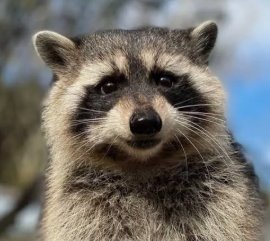

In [527]:
from PIL import Image
import torch
import torchvision.transforms as T
from torchvision.transforms import ToPILImage

# Helper function: tensor -> PIL image
to_pil = ToPILImage()

# Suppose you have a PIL image
test_image_pil = Image.open("raccoon.png").convert("RGB")

# Transform to tensor (match DINO input)
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )
])

test_image_tensor = transform(test_image_pil).to(device) 
test_image_pil

In [528]:
roc_info = get_region_of_competence(test_image_tensor.to(device), k=10)
print("Region of Competence (RoC):", roc_info)

✅ Closest Partition: 1
Top-10 RoC labels: [66 66 66 66 66 66 66 66 66 15]
Region of Competence (RoC): {'partition_id': 1, 'neighbor_indices_local': array([   7,  809,  485, 1090,  769,  885, 1656,  855, 2604,  116]), 'neighbor_indices_global': array([  16, 2475, 1443, 3391, 2352, 2678, 5109, 2586, 7990,  353]), 'neighbor_labels': array([66, 66, 66, 66, 66, 66, 66, 66, 66, 15]), 'distances': array([4026.1636, 4033.0466, 4035.9502, 4037.3503, 4038.4136, 4038.6855,
       4039.0818, 4041.5627, 4042.3015, 4042.6123], dtype=float32)}


In [514]:
img_raw = test_set.dataset[2777][0]  # original image tensor (C,H,W)
img_raw.size()

test_image_tensor = img_raw 

In [515]:
test_image_tensor.size()

torch.Size([3, 32, 32])

In [516]:
roc_info = get_region_of_competence(test_image_tensor.to(device), k=10)
print("Region of Competence (RoC):", roc_info)

✅ Closest Partition: 6
Top-10 RoC labels: [ 2 35  2  2 35 35  2 98  2  2]
Region of Competence (RoC): {'partition_id': 6, 'neighbor_indices_local': array([139, 120,  52,  31, 313, 178, 125, 322, 414, 402]), 'neighbor_indices_global': array([2577, 2245,  986,  571, 5823, 3130, 2341, 5962, 7927, 7697]), 'neighbor_labels': array([ 2, 35,  2,  2, 35, 35,  2, 98,  2,  2]), 'distances': array([3958.395 , 3970.3027, 3972.0398, 3973.6038, 3974.372 , 3975.522 ,
       3977.3271, 3978.7466, 3978.754 , 3978.758 ], dtype=float32)}


In [529]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

def show_region_of_competence(roc_info, dataset, num_images=10):
    """
    Visualize the nearest neighbors (RoC) for a test image.
    
    Args:
        roc_info (dict): Output from get_region_of_competence().
        dataset (torch.utils.data.Dataset): Dataset containing the images.
        num_images (int): Number of neighbors to visualize.
    """
    neighbor_indices = roc_info["neighbor_indices_global"] if "neighbor_indices_global" in roc_info else None
    if neighbor_indices is None:
        print("❌ No neighbor indices found in roc_info.")
        return

    num_images = min(num_images, len(neighbor_indices))
    fig, axes = plt.subplots(1, num_images, figsize=(2 * num_images, 3))

    for i, ax in enumerate(axes):
        idx = neighbor_indices[i]
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()  # CHW → HWC

        # Undo normalization if dataset is normalized
        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis("off")

    plt.suptitle("Region of Competence (Nearest Neighbors)")
    plt.show()


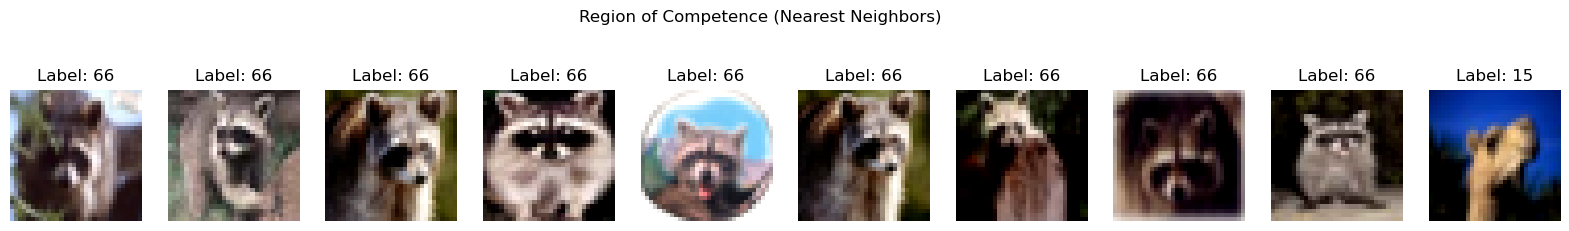

In [530]:
show_region_of_competence(roc_info, val_set, num_images=10)

In [531]:
roc_info

{'partition_id': 1,
 'neighbor_indices_local': array([   7,  809,  485, 1090,  769,  885, 1656,  855, 2604,  116]),
 'neighbor_indices_global': array([  16, 2475, 1443, 3391, 2352, 2678, 5109, 2586, 7990,  353]),
 'neighbor_labels': array([66, 66, 66, 66, 66, 66, 66, 66, 66, 15]),
 'distances': array([4026.1636, 4033.0466, 4035.9502, 4037.3503, 4038.4136, 4038.6855,
        4039.0818, 4041.5627, 4042.3015, 4042.6123], dtype=float32)}

In [532]:
def compute_all_model_competence(roc_info, partition_models, global_models, full_valset, partition_to_global, device="cuda"):
    """
    Compute competence of both partition-specific models and global models on the RoC.

    roc_info: dict from get_region_of_competence (contains neighbor_indices_global and neighbor_labels)
    partition_models: dict {partition_id: {model_name: model_obj, ...}, ...}
    global_models: list of models trained on all classes
    full_valset: validation dataset
    device: "cuda" or "cpu"

    Returns:
        competence_dict: {"global": {model_name: score}, "partition": {model_name: score}}
    """
    neighbor_indices = roc_info["neighbor_indices_global"]
    true_labels = roc_info["neighbor_labels"]
    partition_id = roc_info["partition_id"]

    # Gather models for this partition
    part_models_dict = partition_models.get(str(partition_id), {})
    partition_classes = partition_to_global[str(partition_id)]
    print(partition_classes)
    
    competence_dict = {"global": {}, "partition": {}}

    # ---------------- Global models ----------------
    for idx, model in enumerate(global_models):
        model.eval()
        correct = 0
        for idx_img, true_label in zip(neighbor_indices, true_labels):
            img, _ = full_valset[idx_img]
            img = img.unsqueeze(0).to(device)
            if img.shape[1] == 1:
                img = img.repeat(1, 3, 1, 1)
            img = torch.nn.functional.interpolate(img, size=(32,32), mode="bilinear", align_corners=False)
            with torch.no_grad():
                logits = model(img)
                pred = logits.argmax(dim=1).item()
            if pred == true_label:
                correct += 1
        competence_dict["global"][f"global_model_{idx}"] = correct / len(neighbor_indices)

    # ---------------- Partition models ----------------
    for model_name, model in part_models_dict.items():
        model.eval()
        correct = 0
        for idx_img, true_label in zip(neighbor_indices, true_labels):
            img, _ = full_valset[idx_img]
            img = img.unsqueeze(0).to(device)
            if img.shape[1] == 1:
                img = img.repeat(1, 3, 1, 1)
            img = torch.nn.functional.interpolate(img, size=(32,32), mode="bilinear", align_corners=False)
            with torch.no_grad():
                logits = model(img)
                pred = logits.argmax(dim=1).item()
            if partition_classes[pred] == true_label:
                correct += 1
        competence_dict["partition"][model_name] = correct / len(neighbor_indices)

    return competence_dict

In [533]:
partition_to_global = {}
for pid, cls_names in partitions.items():
    partition_to_global[pid] = [full_class_to_idx[c] for c in cls_names]

partition_to_global["all_classes"] = list(range(100))

In [534]:
competences = compute_all_model_competence(
    roc_info,
    partition_models=partition_models,
    global_models=global_models,
    full_valset=val_set,
    partition_to_global=partition_to_global,
    device=device
)

print("Global model competences:", competences["global"])
print(f"Partition {roc_info['partition_id']} model competences:", competences["partition"])

[3, 4, 15, 19, 21, 27, 29, 30, 31, 32, 34, 36, 38, 42, 43, 44, 50, 55, 63, 64, 65, 66, 67, 72, 73, 74, 75, 80, 88, 91, 93, 95, 97]
Global model competences: {'global_model_0': 1.0, 'global_model_1': 1.0, 'global_model_2': 0.9}
Partition 1 model competences: {'resnet50': 0.9, 'densenet169': 0.9, 'mobilenet_v2': 0.7}


In [535]:
roc_info

{'partition_id': 1,
 'neighbor_indices_local': array([   7,  809,  485, 1090,  769,  885, 1656,  855, 2604,  116]),
 'neighbor_indices_global': array([  16, 2475, 1443, 3391, 2352, 2678, 5109, 2586, 7990,  353]),
 'neighbor_labels': array([66, 66, 66, 66, 66, 66, 66, 66, 66, 15]),
 'distances': array([4026.1636, 4033.0466, 4035.9502, 4037.3503, 4038.4136, 4038.6855,
        4039.0818, 4041.5627, 4042.3015, 4042.6123], dtype=float32)}

In [536]:
import torch
import torch.nn.functional as F
import numpy as np

# ------------------------
# Helper: prepare image tensor
# ------------------------
def prepare_image(img_tensor, target_size=(32,32)):
    """
    Ensure the image tensor has batch dimension and 3 channels, and resize.
    """
    # Add batch dimension if missing
    if img_tensor.dim() == 3:
        img_tensor = img_tensor.unsqueeze(0)  # (1, C, H, W)

    # Ensure 3 channels
    if img_tensor.shape[1] == 1:
        img_tensor = img_tensor.repeat(1, 3, 1, 1)

    # Resize
    img_tensor = F.interpolate(img_tensor, size=target_size, mode="bilinear", align_corners=False)
    img_tensor = cifar_transform(img_tensor[0]).unsqueeze(0)  
    return img_tensor

In [537]:
def aggregate_predictions_separate(
    img_tensor, roc_info, partition_models, global_models, competences, partition_to_global, device="cuda"
):
    img = img_tensor.unsqueeze(0).to(device) 
    for idx, model in enumerate(global_models): 
        pred = model(img) 
        print(pred.argmax())

    partitioned_models = partition_models[str(roc_info['partition_id'])]   

    model_names = list(partitioned_models.keys()) 

    for model_name in model_names: 
        pred = partitioned_models[model_name](img)
        print(pred.argmax())


In [538]:
aggregate_predictions_separate(
    test_image_tensor,
    roc_info,
    partition_models,
    global_models,
    competences,
    partition_to_global,
    device=device
)

tensor(66, device='cuda:2')
tensor(66, device='cuda:2')
tensor(66, device='cuda:2')
tensor(21, device='cuda:2')
tensor(21, device='cuda:2')
tensor(32, device='cuda:2')


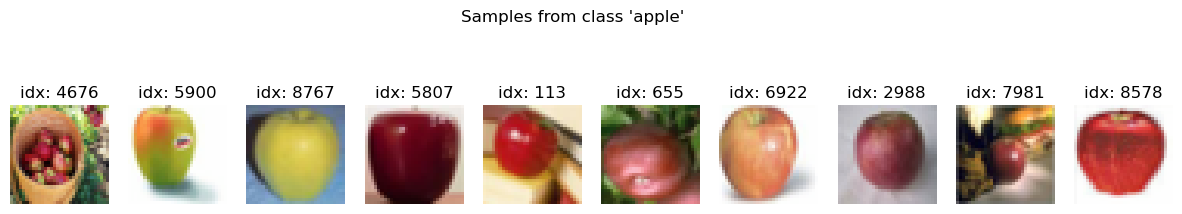

In [231]:
import matplotlib.pyplot as plt
import numpy as np

def show_class_samples_global_idx(subset, class_name, num_samples=10):
    """
    Display num_samples images from a Subset of CIFAR-100 belonging to class_name,
    and show their indices in the original dataset (global indices).
    
    Args:
        subset: torch.utils.data.Subset
        class_name: str, class to show
        num_samples: int
    """
    dataset = subset.dataset
    class_to_idx = dataset.class_to_idx
    target_label = class_to_idx[class_name]
    
    imgs = []
    global_indices = []
    
    for local_idx, original_idx in enumerate(subset.indices):
        img, label = dataset[original_idx]
        if label == target_label:
            imgs.append(img)
            global_indices.append(original_idx)
        if len(imgs) >= num_samples:
            break

    if not imgs:
        print(f"No images found for class '{class_name}'")
        return

    # Un-normalize for display
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    plt.figure(figsize=(15,3))
    for i, (img, idx) in enumerate(zip(imgs, global_indices)):
        np_img = img.numpy().transpose(1,2,0)
        np_img = (np_img * std + mean).clip(0,1)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(np_img)
        plt.axis('off')
        plt.title(f"idx: {idx}")
    plt.suptitle(f"Samples from class '{class_name}'")
    plt.show()

# Example usage:
show_class_samples_global_idx(val_set, class_name="apple", num_samples=10)


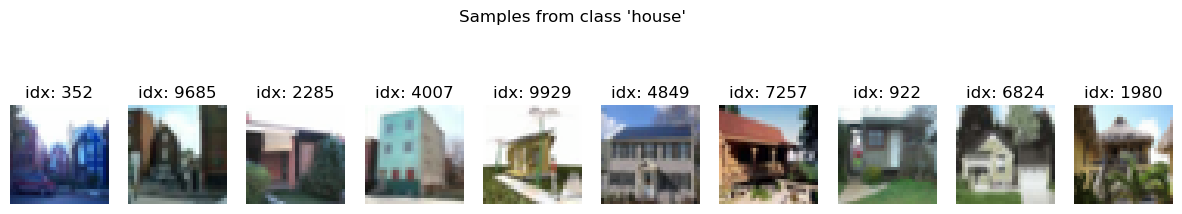

In [464]:
show_class_samples_global_idx(test_set, class_name="house", num_samples=10)

In [375]:
test_set.dataset[113]

(tensor([[[ 0.2654,  0.2654,  0.3042,  ...,  2.3396,  2.3590,  2.3590],
          [ 0.3042,  0.3042,  0.3430,  ...,  2.3009,  2.3202,  2.3202],
          [ 0.3430,  0.3430,  0.3817,  ...,  2.3202,  2.3396,  2.3202],
          ...,
          [ 2.3978,  2.3590,  2.3784,  ...,  1.8550,  2.2815,  2.3202],
          [ 2.4365,  2.3590,  2.3396,  ...,  1.5061,  2.0489,  2.3396],
          [ 2.4559,  2.3784,  2.3396,  ...,  0.9439,  1.6418,  2.1070]],
 
         [[-0.7859, -0.7859, -0.7466,  ...,  2.1445,  2.1445,  2.1445],
          [-0.7859, -0.7859, -0.7466,  ...,  2.1051,  2.1248,  2.1051],
          [-0.7662, -0.7662, -0.7269,  ...,  2.1248,  2.1248,  2.1051],
          ...,
          [ 2.2625,  2.2035,  2.2428,  ...,  1.1021,  1.8888,  2.1445],
          [ 2.2821,  2.2821,  2.3018,  ...,  0.2171,  1.2594,  1.9871],
          [ 2.1248,  2.2231,  2.3018,  ..., -0.9236,  0.3351,  1.4168]],
 
         [[-0.8362, -0.8167, -0.7776,  ...,  1.7392,  1.7002,  1.6416],
          [-0.8557, -0.8362,